For a particular model --> for a selected fold -->
- From the top 500 samples in the json: correctly predicted set and incorrectly predicted set
- From the bottom 500 samples in the json: correctly predicted set and incorrectly predicted set

For the obtained 4 sets, plot graphs for average disagreement (for n number of explanations) for each compactor.

In [24]:
# Import libraries
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random
import json
from typing import Union
import numpy as np
import itertools
from disagreement import Disagreement
import joblib

In [2]:
from compactor.MaxNonActivatedCompactor import MaxNonActivatedCompactor
from compactor.ActivatedCompactor import ActivatedCompactor
from compactor.MaxCompactor import MaxCompactor

In [3]:
!ls /storage/scratch/e17-fyp-xai/projects/e17-4yp-using-machine-learning-in-high-stake-settings/code/new/model_outputs/artifacts/random_forest_t_1000_md_10/

random_forest_t_1000_md_10_fold_1_2016-01-07.sav
random_forest_t_1000_md_10_fold_2_2015-09-09.sav
random_forest_t_1000_md_10_fold_3_2015-05-12.sav
random_forest_t_1000_md_10_fold_4_2015-01-12.sav
random_forest_t_1000_md_10_fold_5_2014-09-14.sav
random_forest_t_1000_md_10_fold_6_2014-05-17.sav
test_prediction_fold_1_2016-01-07.csv
test_prediction_fold_2_2015-09-09.csv
test_prediction_fold_3_2015-05-12.csv
test_prediction_fold_4_2015-01-12.csv
test_prediction_fold_5_2014-09-14.csv
test_prediction_fold_6_2014-05-17.csv


In [34]:
root = "/storage/scratch/e17-fyp-xai/projects/e17-4yp-using-machine-learning-in-high-stake-settings/code/new/model_outputs/"
model_path = "random_forest_t_1000_md_10/" # Change
model_name = "random_forest_t_1000_md_10_fold_1_2016-01-07.sav" # Change
xai_root = root + "xai/2024/"
art_root = root + "artifacts/"
analysis_path = root + "analysis/2024/"
json_file_path = xai_root + model_path + "all_exp.json"

predictions_file_path = art_root + model_path + "test_prediction_fold_1_2016-01-07.csv" # Change
processed_data_path = "/storage/scratch/e17-fyp-xai/projects/e17-4yp-using-machine-learning-in-high-stake-settings/code/processed_data/processed_final_data_latest.csv"

fold = 'fold1' # Change
n_features_compressed = None
top_10_perc_uncompressed = None
model_type = 'rf' # Types: nn, xgb, lgbm, lr, rf # Change

save_path = analysis_path + model_path + f"disagreement_correct_incorrect/{fold}/"

In [26]:
create_nocomp = True
create_max = True
create_act = True
create_maxnonact = True

In [5]:
# Change directory and import
os.chdir("/storage/scratch/e17-fyp-xai/projects/mad_v3/e17-4yp-using-machine-learning-in-high-stake-settings/code/")
import config
categorical_cols = config.CATEGORICAL_COLS

In [6]:
# Helper functions
# Function to save images
def save_image(caption, path):
    set_path = f'{path}/{caption}.png'
    plt.savefig(set_path)

def make_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [7]:
make_directory(save_path)

In [8]:
# Load predictions - To get the predicted label
predictions = pd.read_csv(predictions_file_path)
predictions.head()

,Unnamed: 0,Project ID,1,Start Date
0,34,d8cfc7857397d7ae2ebb22dc26bfdb6e,0.445872,2016-01-07
1,52,dfc090d2fd5be84f7f6a24bea5d2790d,0.346720,2016-01-07
2,65,e9ad2c8eebe8572a84cec5ae73295265,0.267832,2016-01-07
3,88,3d38e90c9b5e1d64307b6bd005242bcd,0.541232,2016-01-07
4,91,954a9ecb81da087c9171ae152133e19d,0.305244,2016-01-07


In [9]:
# Read dataframe to get actual label and for the categorical columns
processed = pd.read_csv(processed_data_path)
processed.columns

Index(['Unnamed: 0', 'Project ID', 'Project Posted Date', 'Project Type',
       'Project Posted Month', 'Project Subject Category Tree', 'Project Cost',
       'Project Subject Subcategory Tree', 'Project Grade Level Category',
       'Project Resource Category', 'School Metro Type', 'School State',
       'Teacher Project Posted Sequence', 'Label', 'Teacher Success Rate',
       'Teacher Success Rate Imputed', 'School City Success Rate',
       'School City Success Rate Imputed', 'School Success Rate',
       'School Success Rate Imputed', 'School County Success Rate',
       'School County Success Rate Imputed', 'Project Count in State',
       'Project Need Statement Length', 'School City',
       'Project Need Statement', 'Resource Vendor Name', 'Teacher Prefix',
       'Project Short Description Length', 'School County',
       'Project Count in County', 'Project Title', 'Project Essay',
       'Resource Cost Percentage', 'Project Essay Length',
       'School Percentage Free Lun

In [10]:
# Load explanations
explanations = json.load(open(json_file_path))

In [11]:
# Create two dictionaries for correct predictions (top and bottom) and wrong predictions
correct_predictions = {}
incorrect_predictions = {}
xai_keys_list = list(explanations[fold].keys())

# Create the structure of the two empty dictionaries
for xai_key in xai_keys_list:
    correct_predictions[xai_key] = {'top': {},
                                    'bottom': {}}
    incorrect_predictions[xai_key] = {'top': {},
                                      'bottom': {}}

# Categorize as correct and incorrect to fill the empty dictionaries
top_keys = list(explanations[fold][xai_keys_list[0]]['top'].keys())
bottom_keys = list(explanations[fold][xai_keys_list[0]]['bottom'].keys())


# For correct prediction, true label must be 1 - top keys
print("For top keys: true label 1 ------------------------------------------------")
for key in top_keys:
    true_label = processed.loc[processed['Project ID'] == key]['Label'].item()
    # Check each explanation
    for xai_key in xai_keys_list:
        if(true_label == 1):
            print(f"correct prediction {true_label}")
            correct_predictions[xai_key]['top'][key] = explanations[fold][xai_key]['top'][key]

        else:
            print(f"incorrect prediction {true_label}")
            incorrect_predictions[xai_key]['top'][key] = explanations[fold][xai_key]['top'][key]


# For correct prediction, true label must be 0 - bottom keys
print("For bottom keys: true label 0 ------------------------------------------------")
for key in bottom_keys:
    true_label = processed.loc[processed['Project ID'] == key]['Label'].item()
    # Check each explanation
    for xai_key in xai_keys_list:
        if(true_label == 0):
            print(f"correct prediction {true_label}")
            correct_predictions[xai_key]['bottom'][key] = explanations[fold][xai_key]['bottom'][key]

        else:
            print(f"incorrect prediction {true_label}")
            incorrect_predictions[xai_key]['bottom'][key] = explanations[fold][xai_key]['bottom'][key]



For top keys: true label 1 ------------------------------------------------
incorrect prediction 0
incorrect prediction 0
incorrect prediction 0
incorrect prediction 0
incorrect prediction 0
incorrect prediction 0
incorrect prediction 0
incorrect prediction 0
correct prediction 1
correct prediction 1
correct prediction 1
correct prediction 1
correct prediction 1
correct prediction 1
correct prediction 1
correct prediction 1
correct prediction 1
correct prediction 1
correct prediction 1
correct prediction 1
correct prediction 1
correct prediction 1
correct prediction 1
correct prediction 1
incorrect prediction 0
incorrect prediction 0
incorrect prediction 0
incorrect prediction 0
correct prediction 1
correct prediction 1
correct prediction 1
correct prediction 1
incorrect prediction 0
incorrect prediction 0
incorrect prediction 0
incorrect prediction 0
correct prediction 1
correct prediction 1
correct prediction 1
correct prediction 1
incorrect prediction 0
incorrect prediction 0
incorr

In [44]:
# Set n features values
top_10_perc_uncompressed = round(len(explanations[fold][xai_keys_list[0]]['top'][top_keys[0]])* 0.1) 
top_20_perc_uncompressed = round(len(explanations[fold][xai_keys_list[0]]['top'][top_keys[0]])* 0.2)
top_10_perc_uncompressed = round(31* 0.1) 
top_20_perc_uncompressed = round(31* 0.2)
print(top_10_perc_uncompressed)

61


In [13]:
# Get count
print(f"Top list: correct - {len(list(correct_predictions[xai_keys_list[0]]['top'].keys()))}, incorrect - {len(list(incorrect_predictions[xai_keys_list[0]]['top'].keys()))}")
print(f"Bottom list: correct - {len(list(correct_predictions[xai_keys_list[0]]['bottom'].keys()))}, incorrect - {len(list(incorrect_predictions[xai_keys_list[0]]['bottom'].keys()))}")
    

Top list: correct - 337, incorrect - 163
Bottom list: correct - 463, incorrect - 37


Local vs Local explanation disagreement

In [14]:
def disagreement_average(explanations1: dict , explanations2: dict , k: int, features_F: list , method = None, raw_data = None, debug = False) -> dict:
    
    disagreement_mean = {'feature_agreement': 0.0,
                         'rank_agreement': 0.0,
                         'sign_agreement': 0.0,
                         'signed_rank_agreement': 0.0}
    
    for project_id in explanations1.keys():
        if debug:
            print(f"******************Project ID: {project_id}************************")
        
        if len(explanations1[project_id]) < k:
            raise ValueError(f"K should be less than {len(explanations1[project_id])}")
        
        disagreement_calc_2 = Disagreement(explanations1[project_id], explanations2[project_id])
        
        if debug:
            print("Initial Explanation 1 \n",disagreement_calc_2.sorted_explanation1[:k])
            print("Initial Explanation 2 \n",disagreement_calc_2.sorted_explanation2[:k])
            
        if method=="max":
            max_compactor = MaxCompactor(categorical_cols)
            disagreement_calc_2.compact_features(max_compactor)
            
            
        elif method == "activated" and raw_data is not None:
            activated_features = {}
            for feature in categorical_cols:
                activated_features[feature] = f"{feature}_{raw_data[raw_data['Project ID'] == project_id ][feature].values[0]}"
            activated_compactor = ActivatedCompactor(activated_features)
            disagreement_calc_2.compact_features(activated_compactor)
            
        elif method == "maxnonactivated" and raw_data is not None:
            activated_features = {}
            for feature in categorical_cols:
                activated_features[feature] = f"{feature}_{raw_data[raw_data['Project ID'] == project_id ][feature].values[0]}"
            max_non_activated_compactor = MaxNonActivatedCompactor(activated_features)
            disagreement_calc_2.compact_features(max_non_activated_compactor)
            
        if debug:
            print("After Compact Explanation 1 \n",disagreement_calc_2.sorted_explanation1[:k])
            print("After Compact Explanation 2 \n",disagreement_calc_2.sorted_explanation2[:k])
            
            
        disagreement = disagreement_calc_2.get_disagreement(k, features_F)
        
        if debug:
            print("Disagreement : ", disagreement)
        
        for key in list(disagreement_mean.keys()):
            if disagreement[key] == None:
                raise ValueError(f"The value for key '{key}' in disagreement_mean is None.")
            disagreement_mean[key] += disagreement[key]
        
        if debug:
            print("****************************************")

    for key in list(disagreement_mean.keys()):
        disagreement_mean[key] = round(disagreement_mean[key] / len(explanations1.keys()),3)
    
    if debug:
        print("*********************************************")
        print(disagreement_mean)
        print("*********************************************")

    
    return disagreement_mean

In [15]:
def disagreement_for_exp_dict(explanations, exp_name_1, exp_name_2, k_range, method=None, raw_data=None, debug=False):

    # For top list
    disagreement_mean_across_top = {'feature_agreement': [],
                                    'rank_agreement': [],
                                    'sign_agreement': [],
                                    'signed_rank_agreement': []}

    for i in range(1,k_range+1,1):
        explanations_top_comparison = disagreement_average(explanations[exp_name_1]["top"], explanations[exp_name_2]["top"], i, None, method, raw_data, debug)

        for key in list(disagreement_mean_across_top.keys()):
            disagreement_mean_across_top[key].append(explanations_top_comparison[key])

    # For bottom list
    disagreement_mean_across_bottom = {'feature_agreement': [],
                                       'rank_agreement': [],
                                       'sign_agreement': [],
                                       'signed_rank_agreement': []}

    for i in range(1,k_range+1,1):
        explanations_bottom_comparison = disagreement_average(explanations[exp_name_1]["bottom"], explanations[exp_name_2]["bottom"], i, None,method, raw_data, debug)

        for key in list(disagreement_mean_across_bottom.keys()):
            disagreement_mean_across_bottom[key].append(explanations_bottom_comparison[key])

    return disagreement_mean_across_top, disagreement_mean_across_bottom

In [16]:
# Function for plotting
%matplotlib inline
import matplotlib.pyplot as plt
def plot_average_across_n_projects_various_k_features(disagreement_mean_across_top_correct, disagreement_mean_across_bottom_correct, disagreement_mean_across_top_incorrect, disagreement_mean_across_bottom_incorrect, feature_n, caption, key_1, key_2, type):

    feature_range = range(1, feature_n+1, 1)

    # Create separate subplots for each agreement metric
    fig, axs = plt.subplots(4, 1, figsize=(10, 16))

    # Plot Feature Agreement for top k
    axs[0].plot(feature_range, disagreement_mean_across_top_correct["feature_agreement"], label='Feature Agreement (Top - Correct Predictions)', marker='o', color='b')
    axs[0].plot(feature_range, disagreement_mean_across_bottom_correct["feature_agreement"], label='Feature Agreement (Bottom - Correct Predictions)', linestyle='--', marker='o', color='r')
    axs[0].plot(feature_range, disagreement_mean_across_top_incorrect["feature_agreement"], label='Feature Agreement (Top - Incorrect Predictions)', marker='o', color='#ee82ee')
    axs[0].plot(feature_range, disagreement_mean_across_bottom_incorrect["feature_agreement"], label='Feature Agreement (Bottom - Incorrect Prediction)', linestyle='--', marker='o', color='#6a5acd')
    axs[0].set_xlabel('Number of Features (Top K)')
    axs[0].set_ylabel('Agreement Score')
    axs[0].set_title('Feature Agreement vs. Number of Features (Top K)')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Rank Agreement for top k
    axs[1].plot(feature_range, disagreement_mean_across_top_correct["rank_agreement"], label='Rank Agreement (Top - Correct Predictions)', marker='s', color='g')
    axs[1].plot(feature_range, disagreement_mean_across_bottom_correct["rank_agreement"], label='Rank Agreement (Bottom - Correct Predictions)', linestyle='--', marker='s', color='m')
    axs[1].plot(feature_range, disagreement_mean_across_top_incorrect["rank_agreement"], label='Rank Agreement (Top - Incorrect Predictions)', marker='s', color='#3cb371')
    axs[1].plot(feature_range, disagreement_mean_across_bottom_incorrect["rank_agreement"], label='Rank Agreement (Bottom - Incorrect Predictions)', linestyle='--', marker='s', color='#ffa500')
    axs[1].set_xlabel('Number of Features (Top K)')
    axs[1].set_ylabel('Agreement Score')
    axs[1].set_title('Rank Agreement vs. Number of Features (Top K)')
    axs[1].legend()
    axs[1].grid(True)

    # Plot Sign Agreement for top k
    axs[2].plot(feature_range, disagreement_mean_across_top_correct["sign_agreement"], label='Sign Agreement (Top - Correct Predictions)', marker='^', color='c')
    axs[2].plot(feature_range, disagreement_mean_across_bottom_correct["sign_agreement"], label='Sign Agreement (Bottom - Correct Predictions)', linestyle='--', marker='^', color='y')
    axs[2].plot(feature_range, disagreement_mean_across_top_incorrect["sign_agreement"], label='Sign Agreement (Top - Incorrect Predictions)', marker='^', color='#ff6347')
    axs[2].plot(feature_range, disagreement_mean_across_bottom_incorrect["sign_agreement"], label='Sign Agreement (Bottom - Incorrect Predictions)', linestyle='--', marker='^', color='#46da05')
    axs[2].set_xlabel('Number of Features (Top K)')
    axs[2].set_ylabel('Agreement Score')
    axs[2].set_title('Sign Agreement vs. Number of Features (Top K)')
    axs[2].legend()
    axs[2].grid(True)

    # Plot Signed Rank Agreement for top k
    axs[3].plot(feature_range, disagreement_mean_across_top_correct["signed_rank_agreement"], label='Signed Rank Agreement (Top - Correct Predictions)', marker='x', color='k')
    axs[3].plot(feature_range, disagreement_mean_across_bottom_correct["signed_rank_agreement"], label='Signed Rank Agreement (Bottom - Correct Predictions)', linestyle='--', marker='x', color='orange')
    axs[3].plot(feature_range, disagreement_mean_across_top_incorrect["signed_rank_agreement"], label='Signed Rank Agreement (Top - Incorrect Predictions)', marker='x', color='#463505')
    axs[3].plot(feature_range, disagreement_mean_across_bottom_incorrect["signed_rank_agreement"], label='Signed Rank Agreement (Bottom - Incorrect Predictions)', linestyle='--', marker='x', color='#0000ff')
    axs[3].set_xlabel('Number of Features (Top K)')
    axs[3].set_ylabel('Agreement Score')
    axs[3].set_title('Signed Rank Agreement vs. Number of Features (Top K)')
    axs[3].legend()
    axs[3].grid(True)

    # Adjust spacing between subplots
    plt.tight_layout()
    #plt.suptitle(f'Agreement variation for {key_1} vs {key_2} for {type}')

    # Show the plots
    
    save_image(caption, save_path)
    plt.show()

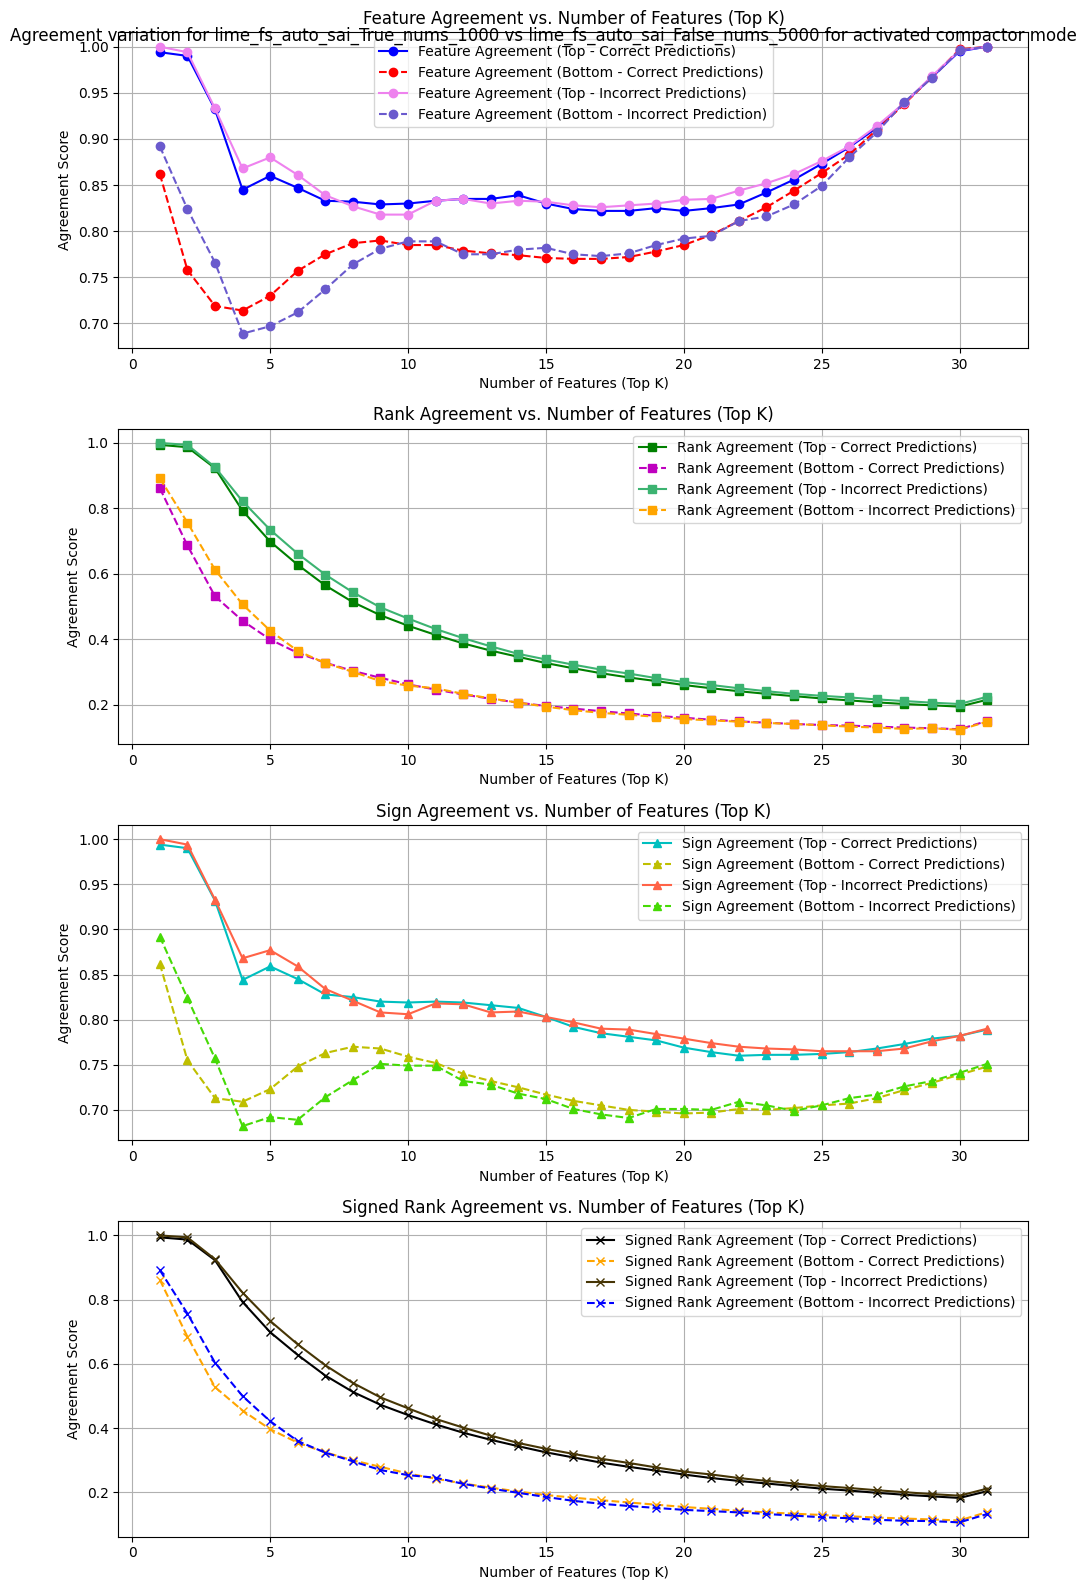

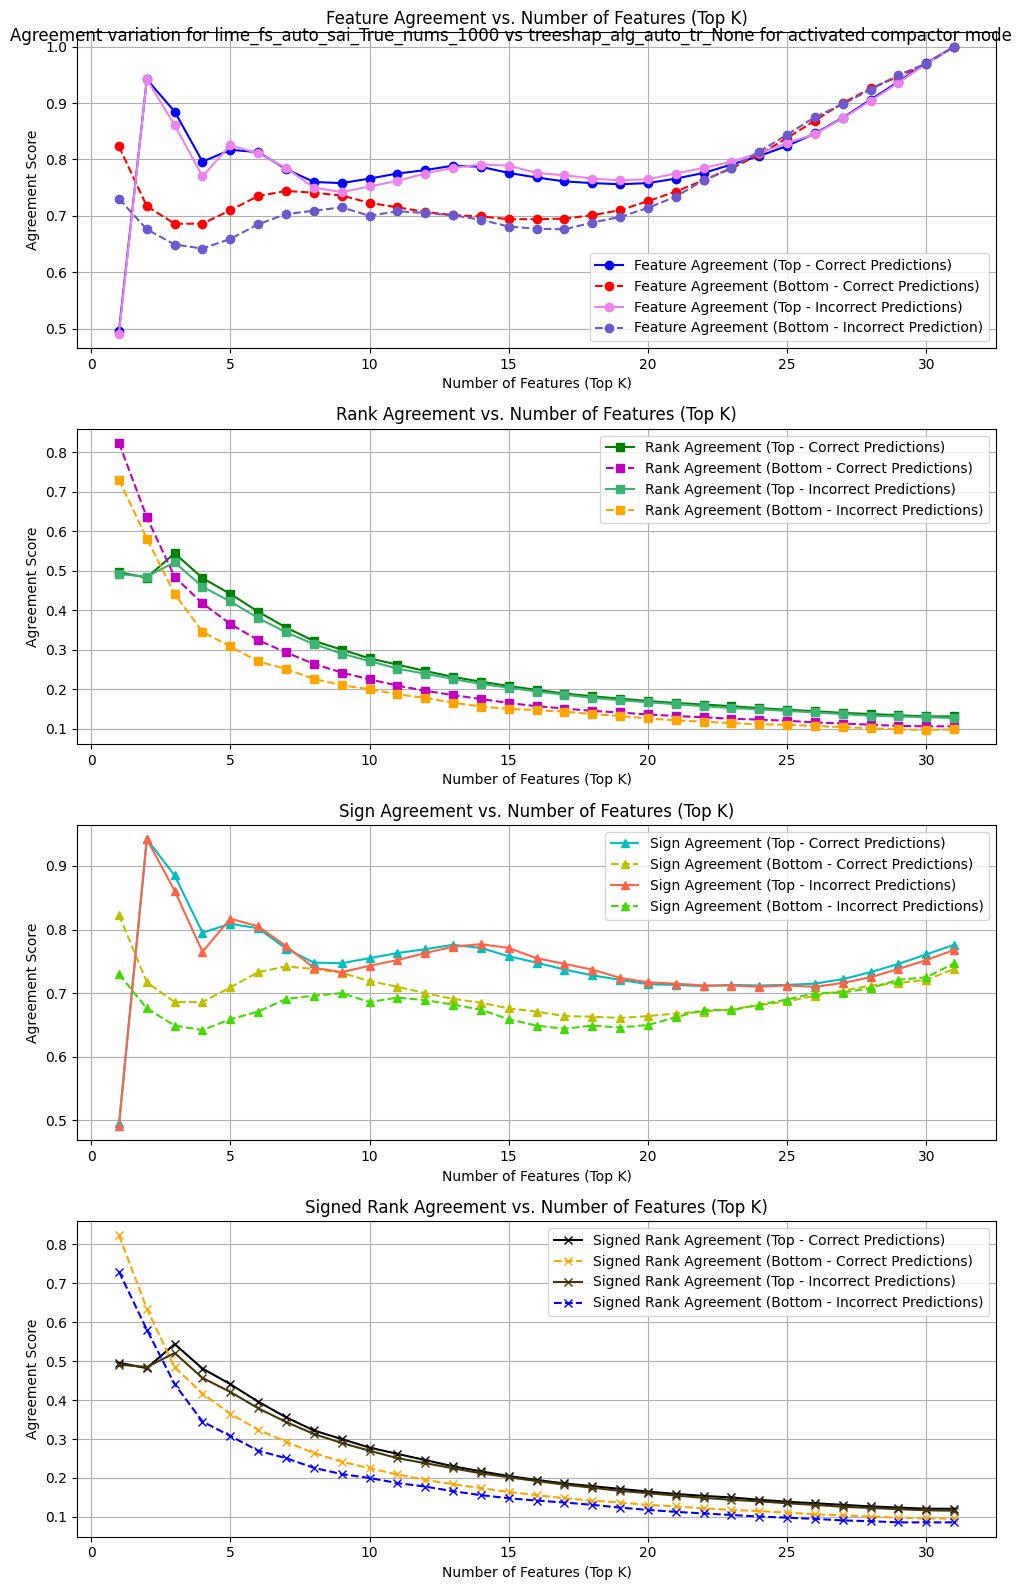

KeyboardInterrupt: 

In [18]:
# Find the diasgreement among all local explanations
for key_pair in list(itertools.combinations(xai_keys_list, 2)):
    # Top 10% with no compactor
    if create_nocomp:
        dm_top_correct_no_comp_10_perc, dm_bottom_correct_no_comp_10_perc = disagreement_for_exp_dict(correct_predictions, key_pair[0], key_pair[1], top_10_perc_uncompressed)
        dm_top_incorrect_no_comp_10_perc, dm_bottom_incorrect_no_comp_10_perc = disagreement_for_exp_dict(incorrect_predictions, key_pair[0], key_pair[1], top_10_perc_uncompressed)
        plot_no_comp_10_perc_name = f"{key_pair[0]}_vs_{key_pair[1]}_10%_no_comp"
        plot_average_across_n_projects_various_k_features(dm_top_correct_no_comp_10_perc, dm_bottom_correct_no_comp_10_perc, dm_top_incorrect_no_comp_10_perc, dm_bottom_incorrect_no_comp_10_perc, top_10_perc_uncompressed, plot_no_comp_10_perc_name, key_pair[0], key_pair[1], "no compactor mode")

    # For max compactor - compressed set of features
    if create_max:
        # explanations, exp_name_1, exp_name 2, k_range, method=None, raw_data=None, debug=False
        dm_top_correct_max, dm_bottom_correct_max = disagreement_for_exp_dict(correct_predictions, key_pair[0], key_pair[1], n_features_compressed, 'max', processed)
        dm_top_incorrect_max, dm_bottom_incorrect_max = disagreement_for_exp_dict(incorrect_predictions, key_pair[0], key_pair[1], n_features_compressed, 'max', processed)
        plot_max_name = f"{key_pair[0]}_vs_{key_pair[1]}_max"
        plot_average_across_n_projects_various_k_features(dm_top_correct_max, dm_bottom_correct_max, dm_top_incorrect_max, dm_bottom_incorrect_max, n_features_compressed, plot_max_name, key_pair[0], key_pair[1], "max compactor mode")
        
    # For activated compactor
    if create_act:
        dm_top_correct_act, dm_bottom_correct_act = disagreement_for_exp_dict(correct_predictions, key_pair[0], key_pair[1], n_features_compressed, 'activated', processed)
        dm_top_incorrect_act, dm_bottom_incorrect_act = disagreement_for_exp_dict(incorrect_predictions, key_pair[0], key_pair[1], n_features_compressed, 'activated', processed)
        plot_act_name = f"{key_pair[0]}_vs_{key_pair[1]}_act"
        plot_average_across_n_projects_various_k_features(dm_top_correct_act, dm_bottom_correct_act, dm_top_incorrect_act, dm_bottom_incorrect_act, n_features_compressed, plot_act_name, key_pair[0], key_pair[1], "activated compactor mode")
        
    # For max nonactivated compactor
    if create_maxnonact:
        dm_top_correct_maxnonact, dm_bottom_correct_maxnonact = disagreement_for_exp_dict(correct_predictions, key_pair[0], key_pair[1], n_features_compressed, 'maxnonactivated', processed)
        dm_top_incorrect_maxnonact, dm_bottom_incorrect_maxnonact = disagreement_for_exp_dict(incorrect_predictions, key_pair[0], key_pair[1], n_features_compressed, 'maxnonactivated', processed)
        plot_maxnonact_name = f"{key_pair[0]}_vs_{key_pair[1]}_maxnonact"
        plot_average_across_n_projects_various_k_features(dm_top_correct_maxnonact, dm_bottom_correct_maxnonact, dm_top_incorrect_maxnonact, dm_bottom_incorrect_maxnonact, n_features_compressed, plot_maxnonact_name, key_pair[0], key_pair[1], "maxnonactivated compactor mode")
        


In [32]:
def load_model_and_feat(model_path, model_name, model_type):
    # Load the model
    model = None
    importance = None
    feat_names = None
    
    if model_type == 'nn':
        model_file_path = f'{model_path}{model_name}' 
        model = keras.models.load_model(model_file_path)
        # Skip the rest

    elif model_type == 'lgbm':
        model_file_path = f'{model_path}{model_name}'
        model = joblib.load(model_file_path)
        # Load the feature importance array
        importance = model.feature_importances_
        # Get the feature names
        feat_names = model.feature_name_

    elif model_type == 'lr':
        model_file_path = f'{model_path}{model_name}'
        model = joblib.load(model_file_path)
        # Load the feature importance array
        importance = model.coef_[0]
        # Get the feature names
        feat_names = model.feature_names_in_
    
    else:
        model_file_path = f'{model_path}{model_name}'
        model = joblib.load(model_file_path)
        # Load the feature importance array
        importance = model.feature_importances_
        # Get the feature names
        feat_names = model.feature_names_in_
    
    return importance, feat_names

In [20]:
# Function to select the top k features and plot
def select_top_features(importance, feat_names):
    # Create df and sort
    df = pd.DataFrame({"Feature": feat_names, "Importance": importance})
    #df_sorted = df.sort_values("Importance", ascending=False)
    df_sorted = df.reindex(df.Importance.abs().sort_values(ascending=False).index)

    return df_sorted

In [27]:
def disagreement_average_global_vs_local(global_exp: dict , local_exp: dict , k: int, features_F: list , method = None, raw_data = None, debug = False) -> dict:
    
    disagreement_mean = {'feature_agreement': 0.0,
                         'rank_agreement': 0.0,
                         'sign_agreement': 0.0,
                         'signed_rank_agreement': 0.0}
    
    for project_id in local_exp.keys():
        if debug:
            print(f"******************Project ID: {project_id}************************")
        
        if len(local_exp[project_id]) < k:
            raise ValueError(f"K should be less than {len(local_exp[project_id])}")
        
        disagreement_calc_2 = Disagreement(global_exp, local_exp[project_id])
        
        if debug:
            print("Initial Explanation 1 \n",disagreement_calc_2.sorted_explanation1[:k])
            print("Initial Explanation 2 \n",disagreement_calc_2.sorted_explanation2[:k])
            
        if method=="max":
            max_compactor = MaxCompactor(categorical_cols)
            disagreement_calc_2.compact_features(max_compactor)
            
            
        elif method == "activated" and raw_data is not None:
            activated_features = {}
            for feature in categorical_cols:
                activated_features[feature] = f"{feature}_{raw_data[raw_data['Project ID'] == project_id ][feature].values[0]}"
            activated_compactor = ActivatedCompactor(activated_features)
            disagreement_calc_2.compact_features(activated_compactor)
            
        elif method == "maxnonactivated" and raw_data is not None:
            activated_features = {}
            for feature in categorical_cols:
                activated_features[feature] = f"{feature}_{raw_data[raw_data['Project ID'] == project_id ][feature].values[0]}"
            max_non_activated_compactor = MaxNonActivatedCompactor(activated_features)
            disagreement_calc_2.compact_features(max_non_activated_compactor)
            
        if debug:
            print("After Compact Explanation 1 \n",disagreement_calc_2.sorted_explanation1[:k])
            print("After Compact Explanation 2 \n",disagreement_calc_2.sorted_explanation2[:k])
            
            
        disagreement = disagreement_calc_2.get_disagreement(k, features_F)
        
        if debug:
            print("Disagreement : ", disagreement)
        
        for key in list(disagreement_mean.keys()):
            if disagreement[key] == None:
                raise ValueError(f"The value for key '{key}' in disagreement_mean is None.")
            disagreement_mean[key] += disagreement[key]
        
        if debug:
            print("****************************************")

    for key in list(disagreement_mean.keys()):
        disagreement_mean[key] = round(disagreement_mean[key] / len(local_exp.keys()),3)
    
    if debug:
        print("*********************************************")
        print(disagreement_mean)
        print("*********************************************")

    
    return disagreement_mean

In [28]:
def disagreement_for_exp_dict_global_vs_local(global_exp, explanations, local_exp_name, k_range, method=None, raw_data=None, debug=False):

    # For top list
    disagreement_mean_across_top = {'feature_agreement': [],
                                    'rank_agreement': [],
                                    'sign_agreement': [],
                                    'signed_rank_agreement': []}

    for i in range(1,k_range+1,1):
        explanations_top_comparison = disagreement_average_global_vs_local(global_exp, explanations[local_exp_name]["top"], i, None, method, raw_data, debug)

        for key in list(disagreement_mean_across_top.keys()):
            disagreement_mean_across_top[key].append(explanations_top_comparison[key])

    # For bottom list
    disagreement_mean_across_bottom = {'feature_agreement': [],
                                       'rank_agreement': [],
                                       'sign_agreement': [],
                                       'signed_rank_agreement': []}

    for i in range(1,k_range+1,1):
        explanations_bottom_comparison = disagreement_average_global_vs_local(global_exp, explanations[local_exp_name]["bottom"], i, None,method, raw_data, debug)

        for key in list(disagreement_mean_across_bottom.keys()):
            disagreement_mean_across_bottom[key].append(explanations_bottom_comparison[key])

    return disagreement_mean_across_top, disagreement_mean_across_bottom

In [42]:
global_importance, feat_names = load_model_and_feat(art_root+model_path, model_name, model_type)
print(global_importance, feat_names)
global_explanation = select_top_features(global_importance, feat_names)
global_explanation.values

[2.43579555e-02 2.18324905e-01 2.84031228e-02 2.99218606e-02
 1.07009094e-02 3.88556406e-02 1.18337382e-03 6.69666160e-02
 3.87013022e-03 3.82134501e-02 6.38238934e-04 1.71613494e-02
 9.27232279e-03 6.55490038e-03 1.73257014e-02 3.70382308e-02
 1.24885725e-02 1.65429951e-02 1.05843956e-01 6.62110273e-04
 1.50740304e-02 9.74534362e-04 4.42241555e-03 1.19998268e-03
 1.42235423e-03 5.63123030e-04 2.22963695e-04 1.20223758e-04
 5.50799645e-04 3.24593288e-04 2.64908347e-04 5.38710036e-04
 0.00000000e+00 8.01635318e-04 4.80638821e-05 1.09756639e-05
 1.20968074e-04 4.17879174e-05 5.45699460e-05 2.41822293e-04
 0.00000000e+00 4.64560161e-04 2.90977785e-05 4.31915318e-06
 3.63666004e-04 1.42337490e-04 2.85613709e-04 1.91960607e-04
 0.00000000e+00 1.27756956e-03 1.80304064e-04 2.05925287e-05
 3.12896389e-04 1.33632098e-03 6.71798712e-04 8.18801917e-04
 0.00000000e+00 1.54739143e-03 4.40009055e-04 8.79076593e-05
 2.84203940e-04 4.72301553e-04 4.06636678e-04 5.83565303e-04
 0.00000000e+00 9.953185

array([['Project Cost', 0.21832490517874864],
       ['Resource Cost', 0.10584395574442541],
       ['School Success Rate', 0.06696661597145076],
       ...,
       ['Project Subject Subcategory Tree_Special Needs, Warmth, Care & Hunger',
        0.0],
       ['Project Subject Subcategory Tree_Team Sports, Visual Arts', 0.0],
       ['Project Subject Subcategory Tree_Gym & Fitness, Warmth, Care & Hunger',
        0.0]], dtype=object)

In [45]:

for local_key in xai_keys_list:
    # Top 10% with no compactor
    if create_nocomp:
        dm_top_correct_no_comp_10_perc, dm_bottom_correct_no_comp_10_perc = disagreement_for_exp_dict_global_vs_local(global_explanation.values, correct_predictions, local_key, top_10_perc_uncompressed)
        dm_top_incorrect_no_comp_10_perc, dm_bottom_incorrect_no_comp_10_perc = disagreement_for_exp_dict_global_vs_local(global_explanation.values, incorrect_predictions, local_key, top_10_perc_uncompressed)
        plot_no_comp_10_perc_name = f"Global_vs_{local_key}_10%_no_comp"
        plot_average_across_n_projects_various_k_features(dm_top_correct_no_comp_10_perc, dm_bottom_correct_no_comp_10_perc, dm_top_incorrect_no_comp_10_perc, dm_bottom_incorrect_no_comp_10_perc, top_10_perc_uncompressed, plot_no_comp_10_perc_name, "global", local_key, "no compactor mode")

    # Max compactor
    if create_max:
        dm_top_correct_max, dm_bottom_correct_max = disagreement_for_exp_dict_global_vs_local(global_explanation.values, correct_predictions, local_key, n_features_compressed, 'max', processed)
        dm_top_incorrect_max, dm_bottom_incorrect_max = disagreement_for_exp_dict_global_vs_local(global_explanation.values, incorrect_predictions, local_key, n_features_compressed, 'max', processed)
        plot_max_name = f"Global_vs_{local_key}_max"
        plot_average_across_n_projects_various_k_features(dm_top_correct_max, dm_bottom_correct_max, dm_top_incorrect_max, dm_bottom_incorrect_max, n_features_compressed, plot_max_name, "global", local_key, "max compactor mode")

    # Activated compactor
    if create_act:
        dm_top_correct_act, dm_bottom_correct_act = disagreement_for_exp_dict_global_vs_local(global_explanation.values, correct_predictions, local_key, n_features_compressed, 'activated', processed)
        dm_top_incorrect_act, dm_bottom_incorrect_act = disagreement_for_exp_dict_global_vs_local(global_explanation.values, incorrect_predictions, local_key, n_features_compressed, 'activated', processed)
        plot_act_name = f"Global_vs_{local_key}_activated"
        plot_average_across_n_projects_various_k_features(dm_top_correct_act, dm_bottom_correct_act, dm_top_incorrect_act, dm_bottom_incorrect_act, n_features_compressed, plot_act_name, "global", local_key, "activated compactor mode")
        
    # Max nonactivated compactor |global_exp, explanations, local_exp_name, k_range, method=None, raw_data=None, debug=False
    if create_maxnonact:
        dm_top_correct_maxnonact, dm_bottom_correct_maxnonact = disagreement_for_exp_dict_global_vs_local(global_explanation.values, correct_predictions, local_key, n_features_compressed, 'activated', processed)
        dm_top_incorrect_maxnonact, dm_bottom_incorrect_maxnonact = disagreement_for_exp_dict_global_vs_local(global_explanation.values, incorrect_predictions, local_key, n_features_compressed, 'activated', processed)
        plot_maxnonact_name = f"Global_vs_{local_key}_maxnonactivated"
        plot_average_across_n_projects_various_k_features(dm_top_correct_maxnonact, dm_bottom_correct_maxnonact, dm_top_incorrect_maxnonact, dm_bottom_incorrect_maxnonact, n_features_compressed, plot_maxnonact_name, "global", local_key, "maxactivated compactor mode")
    

KeyboardInterrupt: 